In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import re

In [3]:
PROJECT_ROOT = Path.cwd().parent
OUTPUT_DIR = PROJECT_ROOT / "outputs"

SUMMARY_FILE = OUTPUT_DIR / "earnings_summaries.csv"

In [5]:
df = pd.read_csv(SUMMARY_FILE)
df.head(2)

,date,exchange,q,ticker,transcript,call_datetime,quarter_only,transcript_clean_basic,transcript_nlp,prepared_remarks,qna,prepared_len,qna_len,prepared_summary,qna_summary,api_called
0,"Nov 17, 2022, 5:00 p.m. ET",NYSE: GPS,2022-Q3,GPS,"Prepared Remarks:\nOperator\nGood afternoon, l...",2022-11-17 17:00:00,Q3,"Prepared Remarks:\nOperator\nGood afternoon, l...","Good afternoon, ladies and gentlemen. My name ...","Prepared Remarks:\nOperator\nGood afternoon, l...",Questions & Answers:\nOperator\n[Operator inst...,23689,34247,- Performance: Gap Inc.'s third quarter 2022 n...,- Management indicated that they are prepared ...,True
1,"Feb 10, 2021, 5:00 p.m. ET",NASDAQ: QLYS,2020-Q4,QLYS,Prepared Remarks:\nOperator\nLadies and gentle...,2021-02-10 17:00:00,Q4,Prepared Remarks:\nOperator\nLadies and gentle...,I will now turn the conference over to Mr. Vin...,Prepared Remarks:\nOperator\nLadies and gentle...,Questions and Answers:\nOperator\nThank you. [...,20191,35689,- Performance: Revenues for Q4 2020 grew 12% t...,- Customers are looking for solutions to help ...,True


In [6]:
# shape and columns appear correct 
print(df.shape)
print("\nColumns:")
print(df.columns.tolist())


(497, 16)

Columns:
['date', 'exchange', 'q', 'ticker', 'transcript', 'call_datetime', 'quarter_only', 'transcript_clean_basic', 'transcript_nlp', 'prepared_remarks', 'qna', 'prepared_len', 'qna_len', 'prepared_summary', 'qna_summary', 'api_called']


In [7]:
# all rows contian a summary 
summary_cols = ["prepared_summary", "qna_summary"]
missing_summary_counts = df[summary_cols].isna().sum()
print("Missing summaries:")
print(missing_summary_counts)

Missing summaries:
prepared_summary    0
qna_summary         0
dtype: int64


In [58]:
def char_count(text):
    if not isinstance(text, str):
        return 0
    return len(text)

In [63]:
df["prepared_summary_char_count"] = df["prepared_summary"].apply(word_count)
df["qna_summary_char_count"] = df["qna_summary"].apply(word_count)

In [64]:
#character len seem is higher than expected for 4-6 bullet points
df[[f"{c}_char_count" for c in summary_cols]].describe()

,prepared_summary_char_count,qna_summary_char_count
count,497.000000,497.000000
mean,2571.881288,3039.539235
std,894.225604,1280.557963
min,466.000000,83.000000
25%,1911.000000,2105.000000
50%,2554.000000,3028.000000
75%,3116.000000,3906.000000
max,5226.000000,9025.000000


In [65]:
def word_count(text):
    if not isinstance(text, str):
        return 0
    return len(text.split())

In [66]:
df["prepared_summary_word_count"] =    df["prepared_summary"].apply(word_count)
df["qna_summary_word_count"] = df["qna_summary"].apply(word_count)

Summaries are too verbose compared to expctation from the prompt

In [67]:

df[[f"{c}_word_count" for c in summary_cols]].describe()

,prepared_summary_word_count,qna_summary_word_count
count,497.000000,497.000000
mean,383.388330,461.847082
std,132.361035,192.972265
min,63.000000,15.000000
25%,287.000000,325.000000
50%,375.000000,457.000000
75%,459.000000,591.000000
max,755.000000,1355.000000


In [68]:
def sentence_count(text):
    if not isinstance(text, str):
        return 0
    return len(re.findall(r"[.!?]+", text))

df["prepared_summary_sentence_count"] = df["prepared_summary"].apply(sentence_count)
df["qna_summary_sentence_count"] = df["qna_summary"].apply(sentence_count)


Appear to be lacking conciseness in the summaries. Over 40 'sentences' in some cases and some with 0 which based on other metrics may be a punctuation issue

In [69]:
df[[f"{c}_sentence_count" for c in summary_cols]].describe()

,prepared_summary_sentence_count,qna_summary_sentence_count
count,497.000000,497.000000
mean,18.680080,17.253521
std,8.511393,8.362027
min,0.000000,0.000000
25%,12.000000,11.000000
50%,18.000000,16.000000
75%,24.000000,22.000000
max,46.000000,50.000000


In [70]:
#review summaries with zero sentences
zero_sentence = df[(df['prepared_summary_sentence_count'] == 0) | (df['qna_summary_sentence_count'] == 0)]

In [71]:
# zero sentence summaries have significant word counts (missing punctuation
zero_sentence[['prepared_summary_sentence_count', 'prepared_summary_word_count', 'qna_summary_sentence_count',  'qna_summary_word_count']]

,prepared_summary_sentence_count,prepared_summary_word_count,qna_summary_sentence_count,qna_summary_word_count
1,12,172,0,102
6,0,251,6,155
14,14,197,0,80
55,0,88,20,663
123,0,251,30,655


In [72]:

def bullet_count(text):
    if not isinstance(text, str):
        return 0

    count = 0
    for line in text.splitlines():
        line_clean = line.strip().lower()
        if line_clean.startswith("-"):
            count += 1
    return count


In [73]:
df["prepared_summary_bullet_count"] = df["prepared_summary"].apply(bullet_count)
df["qna_summary_bullet_count"] = df["qna_summary"].apply(bullet_count)

Prompt was for 4-6 bullet points per summary - will need to deduplicate or more precise prompts

In [74]:
df[[f"{c}_bullet_count" for c in summary_cols]].describe()

,prepared_summary_bullet_count,qna_summary_bullet_count
count,497.000000,497.000000
mean,16.060362,18.937626
std,7.458783,7.653413
min,4.000000,0.000000
25%,12.000000,14.000000
50%,14.000000,19.000000
75%,21.000000,24.000000
max,48.000000,55.000000


In [75]:
#prepared summary expectaion was the below sections
EXPECTED_SECTIONS = [
    "Performance",
    "Guidance",
    "Risks",
    "Strategic changes"
]

In [76]:
def section_header_count(text):
    if not isinstance(text, str):
        return 0

    count = 0
    for line in text.splitlines():
        line_clean = line.strip()
        for section in EXPECTED_SECTIONS:
            if (f"{section}") in line_clean:
                count += 1
    return count

In [77]:
df["prepared_summary_section_count"] = df["prepared_summary"].apply(section_header_count)

Appears it is repeating the sections multiple times in most prepared summaries

In [78]:
df['prepared_summary_section_count'].describe()

count    497.000000
mean       9.376258
std        3.749903
min        0.000000
25%        8.000000
50%        8.000000
75%       12.000000
max       24.000000
Name: prepared_summary_section_count, dtype: float64

Compression Ratios

In [79]:
# originalword count
df["prepared_word_count"] = df["prepared_remarks"].apply(word_count)
# compression ratio (summary / original)
df["prepared_word_compression"] = (df["prepared_summary_word_count"] / df["prepared_word_count"])

In [80]:
# originalword count
df["prepared_word_count"] = df["prepared_remarks"].apply(word_count)
# compression ratio (summary / original)
df["prepared_word_compression"] = (df["prepared_summary_word_count"] / df["prepared_word_count"])

In [81]:
df['prepared_word_compression'].describe()

count    497.000000
mean       0.125007
std        0.027726
min        0.035766
25%        0.109740
50%        0.124100
75%        0.140345
max        0.346154
Name: prepared_word_compression, dtype: float64

Prepared remarks summarization, with an average compression ratio of 12.5% is higher than desired ratio of 5-10%

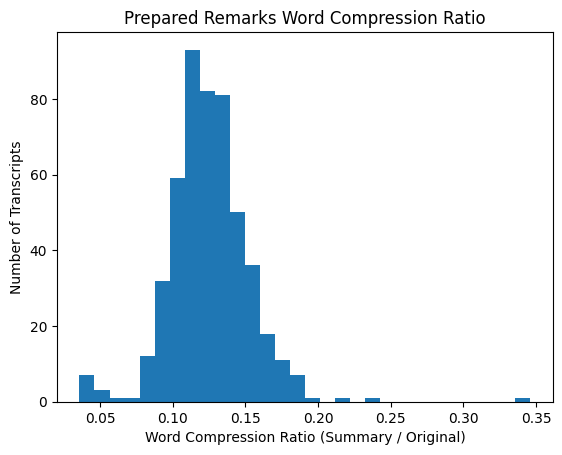

In [82]:
plt.figure()
plt.hist(df["prepared_word_compression"], bins=30)
plt.xlabel("Word Compression Ratio (Summary / Original)")
plt.ylabel("Number of Transcripts")
plt.title("Prepared Remarks Word Compression Ratio")
plt.show()

In [90]:
# original char count
df["prepared_char_count"] = df["prepared_remarks"].apply(char_count)
# compression ratio (summary / original)
df["prepared_char_compression"] = (df["prepared_summary_char_count"] / df["prepared_char_count"])
df['prepared_char_compression'].describe()

count    497.000000
mean       0.134162
std        0.028362
min        0.038480
25%        0.117965
50%        0.132216
75%        0.149655
max        0.356815
Name: prepared_char_compression, dtype: float64

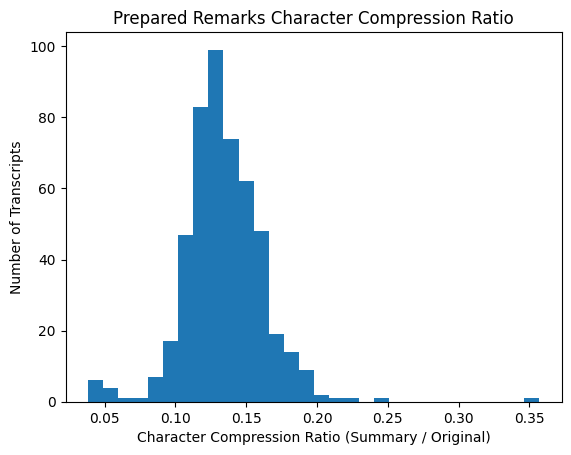

In [91]:
plt.figure()
plt.hist(df["prepared_char_compression"], bins=30)
plt.xlabel("Character Compression Ratio (Summary / Original)")
plt.ylabel("Number of Transcripts")
plt.title("Prepared Remarks Character Compression Ratio")
plt.show()

In [92]:
df["qna_word_count"] = df["qna"].apply(word_count)
df["qna_word_compression"] = (df["qna_summary_word_count"] / df["qna_word_count"])
# outliers need to investigate
df['qna_word_compression'].describe()

count    497.000000
mean       0.105409
std        0.137698
min        0.001572
25%        0.088712
50%        0.096224
75%        0.105282
max        3.034483
Name: qna_word_compression, dtype: float64

In [85]:
outliers = df.loc[df["qna_word_compression"] > 0.5, ["ticker", "date", "qna_word_compression", "qna"]]
outliers = outliers.sort_values(by="qna_word_compression", ascending=False)

There was no Q & A on the outliers

In [86]:
print(df.loc[257, "qna"]), print(df.loc[484, "qna"])

Questions and Answers:
Duration: 16 minutes
Call participants:
Michael Combs -- President and Chief Executive Officer
Brandon O'Brien -- Chief Financial Officer
More CRVL analysis
All earnings call transcripts





Questions and Answers:
Operator
We will now begin the question-and-answer session. [Operator Instructions] Showing no questions. This concludes our question-and-answer session and conference call. [Operator Closing Remarks]
Duration: 18 minutes
Call participants:
Michael Stein -- Chief Executive Officer of Genie Energy; Chief Executive Officer of Genie Retail Energy
Avi Goldin -- Chief Financial Officer
More GNE analysis
All earnings call transcripts







(None, None)

In [87]:
# windsorize to visualize
from scipy.stats.mstats import winsorize

df["qna_word_compression_w"] = winsorize(
    df["qna_word_compression"],
    limits=[0.01, 0.01]
)

Q&A summarization, with an average compression ratio of 10% i better than the prepared remarks but on hte high end of expectations.A few transcripts were anomolous due to no questions on the caLL

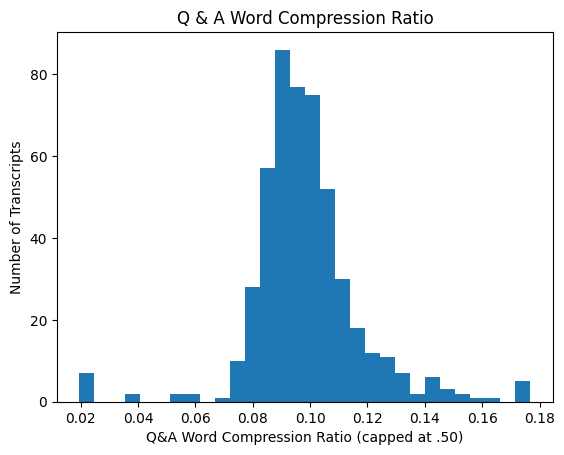

In [88]:
plt.figure()
plt.hist(df["qna_word_compression_w"], bins=30) # remove outliers
plt.xlabel("Q&A Word Compression Ratio (capped at .50)")
plt.ylabel("Number of Transcripts")
plt.title("Q & A Word Compression Ratio")
plt.show()

In [93]:
df["qna_char_count"] = df["qna"].apply(char_count)
df["qna_char_compression"] = (df["qna_summary_char_count"] / df["qna_char_count"])

df['qna_char_compression'].describe()

count    497.000000
mean       0.120129
std        0.134208
min        0.001568
25%        0.102905
50%        0.111542
75%        0.123103
max        3.009346
Name: qna_char_compression, dtype: float64

In [102]:
df["qna_char_compression_w"] = winsorize(
    df["qna_char_compression"],
    limits=[0.01, 0.01]
)

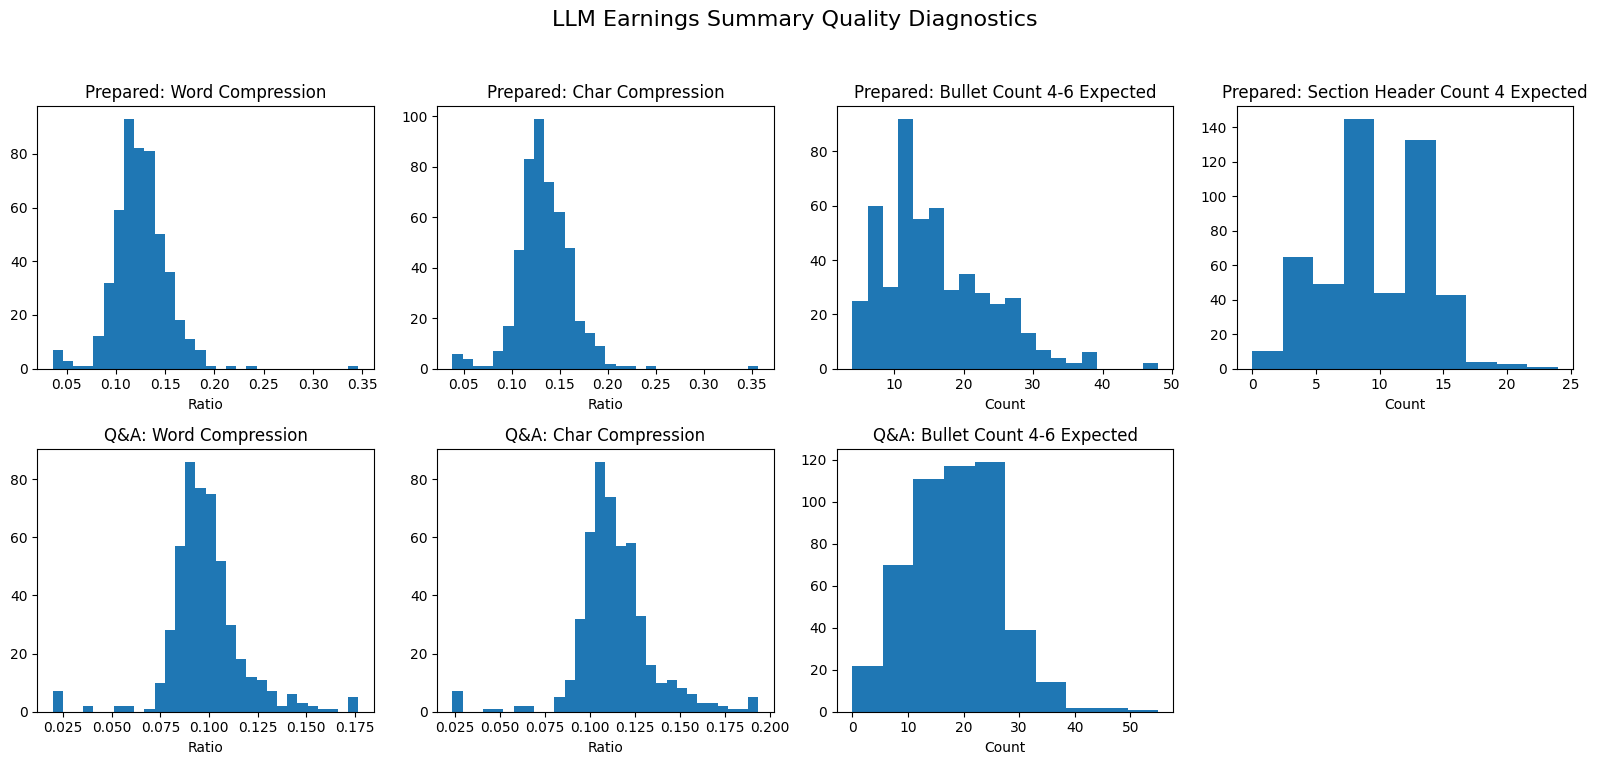

In [110]:
METRICS_FILE = OUTPUT_DIR / "summary_quality_diagnostics.png"
fig, axs = plt.subplots(2, 4, figsize=(16, 8))
fig.suptitle("LLM Earnings Summary Quality Diagnostics", fontsize=16)

# Prepared summaries (row 0)
axs[0, 0].hist(df["prepared_word_compression"], bins=30)
axs[0, 0].set_title("Prepared: Word Compression")
axs[0, 0].set_xlabel("Ratio")

axs[0, 1].hist(df["prepared_char_compression"], bins=30)
axs[0, 1].set_title("Prepared: Char Compression")
axs[0, 1].set_xlabel("Ratio")

axs[0, 2].hist(df["prepared_summary_bullet_count"], bins=20)
axs[0, 2].set_title("Prepared: Bullet Count 4-6 Expected")
axs[0, 2].set_xlabel("Count")

axs[0, 3].hist(df["prepared_summary_section_count"], bins=10)
axs[0, 3].set_title("Prepared: Section Header Count 4 Expected")
axs[0, 3].set_xlabel("Count")

# Q&A summaries (row 1)
axs[1, 0].hist(df["qna_word_compression_w"], bins=30)
axs[1, 0].set_title("Q&A: Word Compression")
axs[1, 0].set_xlabel("Ratio")

axs[1, 1].hist(df["qna_char_compression_w"], bins=30)
axs[1, 1].set_title("Q&A: Char Compression")
axs[1, 1].set_xlabel("Ratio")

axs[1, 2].hist(df["qna_summary_bullet_count"], bins=10)
axs[1, 2].set_title("Q&A: Bullet Count 4-6 Expected")
axs[1, 2].set_xlabel("Count")

# Optional: leave last Q&A chart empty or add another metric later
axs[1, 3].axis("off")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig(METRICS_FILE, dpi=150)
plt.show()
